# Evaluation Pipeline application to random baseline

## Imports

In [2]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
from collections import defaultdict, Counter
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, top_k_accuracy_score, precision_score, recall_score, 
    f1_score, log_loss, hamming_loss, classification_report, confusion_matrix
)
from sklearn.utils import resample
from datasets import Dataset, load_from_disk


## Load data

In [3]:
data_path = os.path.join("..","data","val_baseline")

absolute_path = os.path.abspath(data_path)

print(absolute_path)

# Add the 'baseline' column with the sampled predictions to the test set
dataset_test = load_from_disk(absolute_path)

C:\Users\49176\Unistuff\PP2\prostT5-CLIP\data\val_baseline


In [4]:
dataset_test

Dataset({
    features: ['identifier', 'sequence', 'species', 'baseline'],
    num_rows: 28450
})

## Implement bootstrapping and metrics

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_top_species_metric(results, dataset_test, metric="mcc", top_n=30):
    """
    Plot the top N species by occurrence, showing mean metric (e.g., MCC, precision) with standard deviation.

    Parameters:
    - results: dict, containing mean and std for the metric (e.g., MCC, precision) per species.
    - dataset_test: DataFrame with a 'species' column for occurrence counting.
    - metric: str, "mcc", "precision", "recall", or "f1" to specify which metric to plot.
    - top_n: int, number of top species by occurrence to plot.
    """
    # Count occurrences of each species in dataset_test
    species_counts = pd.Series(dataset_test['species']).value_counts()
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df.index.name = 'species'
    
    # Merge the metric data with the species counts
    results_df = results_df.merge(
        species_counts.rename('count'), 
        left_index=True, 
        right_index=True
    )
    
    # Sort by occurrences and select the top N
    top_species = results_df.sort_values(by='count', ascending=False).head(top_n)
    
    # Define metric column names based on the chosen metric
    metric_mean_col = f"{metric}_mean"
    metric_std_col = f"{metric}_std"
    
    # Check if the specified metric exists in results
    if metric_mean_col not in top_species.columns or metric_std_col not in top_species.columns:
        raise ValueError(f"Metric '{metric}' is not available in the results data.")
    
    # Plot the mean metric with standard deviation as error bars
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=top_species, 
        y=top_species.index, 
        x=metric_mean_col, 
        ci=None  # Disable seaborn's built-in confidence interval calculation
    )
    
    # Add error bars manually
    plt.errorbar(
        x=top_species[metric_mean_col], 
        y=range(len(top_species)),
        xerr=top_species[metric_std_col].values,
        fmt='none', 
        color='black', 
        capsize=5
    )
    
    # Set labels and title dynamically based on the metric
    plt.xlabel(f"Mean {metric.capitalize()}")
    plt.ylabel("Species")
    plt.title(f"Top {top_n} Species by Occurrence and Mean {metric.capitalize()}")
    plt.show()


In [43]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
from tqdm import tqdm
import warnings  # Import warnings module

def evaluate(y_true, y_pred):
    """Evaluates multiple metrics for a given set of predictions."""
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)  # Suppress zero division warnings
        metrics = {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
            "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
            "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
            "precision_micro": precision_score(y_true, y_pred, average="micro", zero_division=0),
            "recall_micro": recall_score(y_true, y_pred, average="micro", zero_division=0),
            "f1_micro": f1_score(y_true, y_pred, average="micro", zero_division=0),
            # "hamming_loss": hamming_loss(y_true, y_pred)
        }
    return metrics

def bootstrap_evaluate(y_true, y_pred, n_bootstraps=1000):
    """Bootstraps the evaluate function to get distributions of metrics."""
    
    bootstrapped_scores = {
        "accuracy": [],
        "precision_macro": [],
        "recall_macro": [],
        "f1_macro": [],
        "precision_micro": [],
        "recall_micro": [],
        "f1_micro": [],
        # "hamming_loss": []
    }
    
    # Use tqdm to show progress of bootstrapping
    for _ in tqdm(range(n_bootstraps), desc="Bootstrapping", miniters=100):
        # Resample with replacement
        indices = np.random.choice(len(y_true), size=len(y_true), replace=True)
        y_true_sample = [y_true[i] for i in indices]
        y_pred_sample = [y_pred[i] for i in indices]

        # Evaluate metrics on the sample
        metrics = evaluate(y_true_sample, y_pred_sample)

        # Append each metric to its respective list in bootstrapped_scores
        for key, value in metrics.items():
            bootstrapped_scores[key].append(value)

    return bootstrapped_scores


In [44]:
dataset_test

Dataset({
    features: ['identifier', 'sequence', 'species', 'baseline'],
    num_rows: 28450
})

In [45]:
assert len(dataset_test['species']) == len(dataset_test["baseline"])

In [ ]:
results = bootstrap_evaluate(dataset_test['species'], dataset_test["baseline"])


In [49]:
results

{'accuracy': [0.07922671353251318,
  0.07729349736379613,
  0.0768365553602812,
  0.07824253075571178,
  0.07841827768014059,
  0.0761335676625659,
  0.07627416520210896,
  0.07641476274165201,
  0.07546572934973637,
  0.0768365553602812,
  0.07725834797891037,
  0.07560632688927944,
  0.0752548330404218,
  0.07455184534270651,
  0.07599297012302285,
  0.07518453427065026,
  0.07750439367311072,
  0.07869947275922672,
  0.0758523725834798,
  0.07500878734622145,
  0.07620386643233744,
  0.07708260105448154,
  0.0758523725834798,
  0.07648506151142355,
  0.0751493848857645,
  0.07553602811950791,
  0.07919156414762742,
  0.07592267135325131,
  0.07588752196836555,
  0.07996485061511424,
  0.07922671353251318,
  0.07764499121265378,
  0.0763444639718805,
  0.07838312829525483,
  0.07666080843585238,
  0.07729349736379613,
  0.07831282952548331,
  0.07894551845342707,
  0.07806678383128295,
  0.07578207381370826,
  0.07546572934973637,
  0.0763444639718805,
  0.07666080843585238,
  0.0775

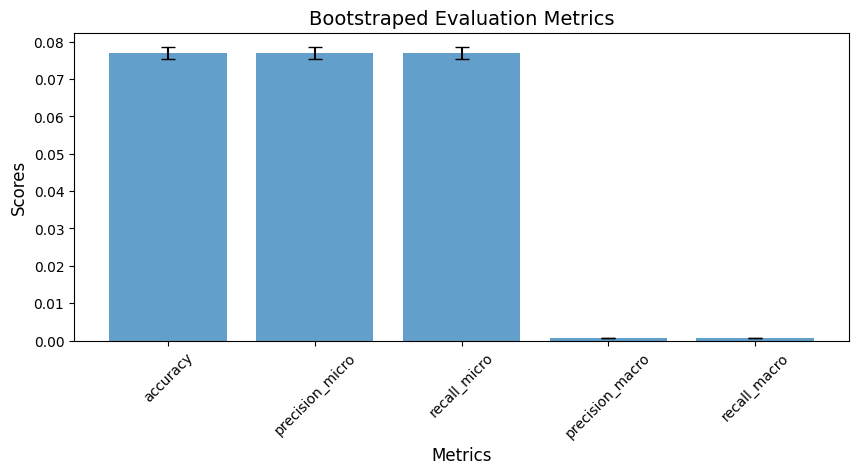

In [52]:


# Assuming `results` is a dictionary with metric names as keys and lists of scores as values
# Example: results = {"accuracy": [list of accuracy scores], "hamming_loss": [list of hamming_loss scores]}

# Calculate mean and standard deviation for each metric
metrics = ["accuracy","precision_micro","recall_micro","precision_macro","recall_macro"]
means = [np.mean(results[metric]) for metric in metrics]
std_devs = [np.std(results[metric]) for metric in metrics]

# Create the bar plot with error bars
plt.figure(figsize=(10, 4))
plt.bar(metrics, means, yerr=std_devs, capsize=5, alpha=0.7)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.title("Bootstraped Evaluation Metrics", fontsize=14)
plt.xticks(rotation=45)
plt.show()


## Accuracy per label

In [16]:

def compute_accuracy_for_sample(y_true_sample, y_pred_sample, unique_labels):
    """
    Compute accuracy for a single bootstrap sample for all unique labels.
    """
    accuracies = {}
    for label in unique_labels:
        y_true_binary = (y_true_sample == label).astype(int)
        y_pred_binary = (y_pred_sample == label).astype(int)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_true_binary, y_pred_binary)
        accuracies[label] = accuracy
    return accuracies

def per_label_bootstrap_accuracy(y_true, y_pred, n_bootstraps=1000, n_jobs=-1):
    """
    Bootstraps to evaluate accuracy per label with mean and standard deviation across bootstraps.
    
    Parameters:
    - y_true: list or array, true labels.
    - y_pred: list or array, predicted labels.
    - n_bootstraps: int, number of bootstrap samples.
    - n_jobs: int, the number of parallel jobs (default is -1 to use all cores).
    
    Returns:
    - per_label_summary: dict, contains mean and standard deviation for accuracy per label.
    """
    
    # Collect unique labels
    unique_labels = np.unique(y_true)
    
    # Perform parallel bootstrapping with tqdm progress bar
    bootstrapped_samples = Parallel(n_jobs=n_jobs)(
        delayed(compute_accuracy_for_sample)(
            np.array(y_true)[np.random.choice(len(y_true), len(y_true), replace=True)],
            np.array(y_pred)[np.random.choice(len(y_pred), len(y_pred), replace=True)],
            unique_labels
        ) for _ in tqdm(range(n_bootstraps), desc="Bootstrapping")
    )
    
    # Initialize dictionary to store bootstrapped accuracies per label
    bootstrapped_accuracies = {label: [] for label in unique_labels}

    # Collect results from all bootstrapped samples
    for sample_accuracies in bootstrapped_samples:
        for label, accuracy in sample_accuracies.items():
            bootstrapped_accuracies[label].append(accuracy)

    # Calculate mean and standard deviation for accuracy per label
    per_label_summary = {}
    for label, accuracies in bootstrapped_accuracies.items():
        per_label_summary[label] = {
            "accuracy_mean": np.mean(accuracies),
            "accuracy_std": np.std(accuracies),
        }
        
    return per_label_summary


In [7]:
# Assuming `y_true` and `y_pred` contain your actual and predicted labels
per_label_summary = per_label_bootstrap_accuracy(dataset_test['species'], dataset_test["baseline"])


Bootstrapping: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [17:46<00:00,  1.07s/it]


{'Abrus precatorius': {'accuracy_mean': 0.9999653427065027, 'accuracy_std': 3.514594007723658e-05}, 'Acanthamoeba polyphaga mimivirus': {'accuracy_mean': 0.9999645342706504, 'accuracy_std': 3.534076195929702e-05}, 'Acanthoscurria gomesiana': {'accuracy_mean': 0.9999299121265378, 'accuracy_std': 4.908299171351709e-05}, 'Acetivibrio thermocellus': {'accuracy_mean': 0.9997902636203867, 'accuracy_std': 8.305905259613417e-05}, 'Acetivibrio thermocellus ': {'accuracy_mean': 0.9997567311072055, 'accuracy_std': 9.365025093911412e-05}, 'Acetoanaerobium sticklandii ': {'accuracy_mean': 0.9998917750439368, 'accuracy_std': 6.084762596246353e-05}, 'Acetobacter aceti': {'accuracy_mean': 0.9999651318101935, 'accuracy_std': 3.594763181401128e-05}, 'Acidianus ambivalens': {'accuracy_mean': 0.9999652372583481, 'accuracy_std': 3.4526627272764887e-05}, 'Acidianus two-tailed virus': {'accuracy_mean': 0.9999630228471004, 'accuracy_std': 3.597099504915561e-05}, 'Acidithiobacillus ferrooxidans ': {'accuracy_m

C:\Users\49176\AppData\Local\Temp\ipykernel_8516\967012130.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


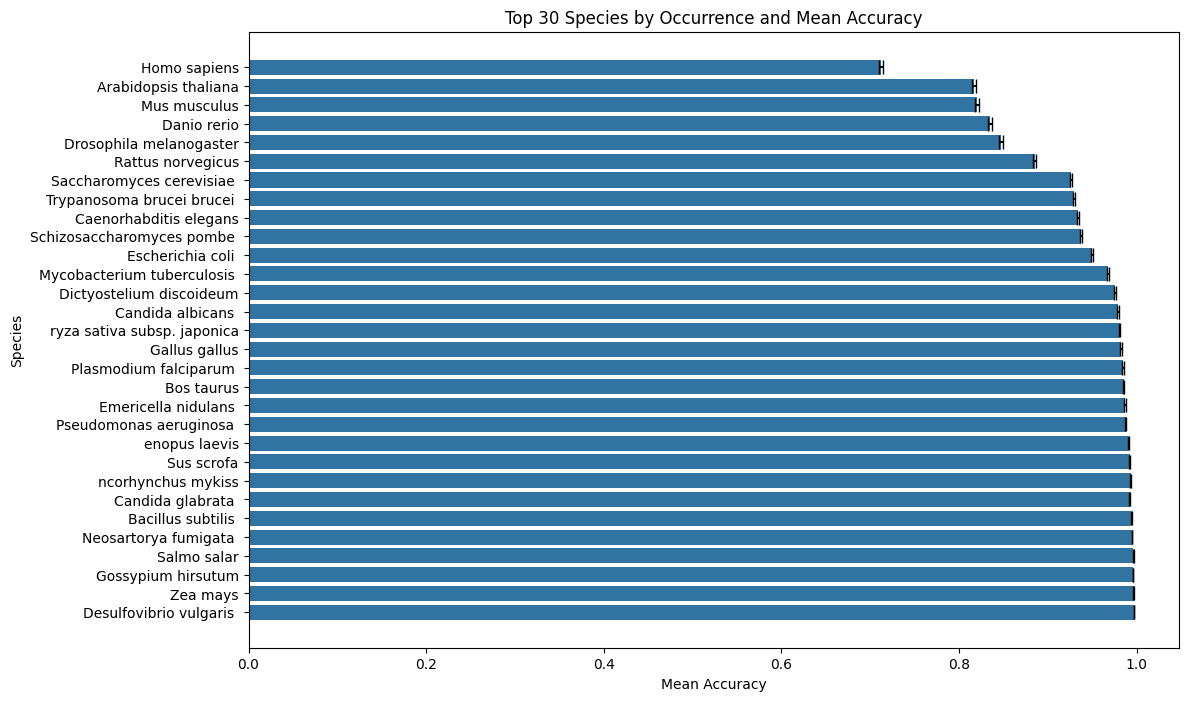

In [14]:
plot_top_species_metric(per_label_summary, dataset_test, metric="accuracy", top_n=30)

## MCC, precison recall and F1


In [24]:
import numpy as np
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, f1_score
from collections import defaultdict
from joblib import Parallel, delayed
from tqdm import tqdm

def compute_metrics_for_sample(y_true_sample, y_pred_sample, unique_labels):
    """
    Compute MCC, Precision, Recall, and F1 for a single bootstrap sample for all unique labels.
    """
    metrics_scores = {}
    for label in unique_labels:
        # Convert labels to binary for the current label
        y_true_binary = (y_true_sample == label).astype(int)
        y_pred_binary = (y_pred_sample == label).astype(int)
        
        # Calculate metrics
        mcc = matthews_corrcoef(y_true_binary, y_pred_binary)
        precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
        recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
        
        # Store metrics
        metrics_scores[label] = {
            "mcc": mcc,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }
    return metrics_scores

def per_label_bootstrap_metrics(y_true, y_pred, n_bootstraps=1000, n_jobs=-1, top_x=None):
    """
    Bootstraps to evaluate MCC, Precision, Recall, and F1 per label with mean and standard deviation across bootstraps.
    
    Parameters:
    - y_true: list or array, true labels.
    - y_pred: list or array, predicted labels.
    - n_bootstraps: int, number of bootstrap samples.
    - n_jobs: int, the number of parallel jobs (default is -1 to use all cores).
    - top_x: int, the number of most prevalent labels to calculate metrics for. If None, all labels are used.
    
    Returns:
    - per_label_summary: dict, contains mean and standard deviation for each metric per label.
    """
    
    # Collect unique labels and their prevalence
    label_counts = np.unique(y_true, return_counts=True)
    label_count_df = pd.DataFrame({'label': label_counts[0], 'count': label_counts[1]})
    
    # Sort labels by prevalence and select top_x labels if specified
    if top_x is not None:
        top_labels = label_count_df.sort_values(by='count', ascending=False).head(top_x)['label']
    else:
        top_labels = label_count_df['label']
        
    # Filter to include only top labels in the unique_labels array
    unique_labels = top_labels.values
    
    # Perform parallel bootstrapping with tqdm progress bar
    bootstrapped_samples = Parallel(n_jobs=n_jobs)(
        delayed(compute_metrics_for_sample)(
            np.array(y_true)[np.random.choice(len(y_true), len(y_true), replace=True)],
            np.array(y_pred)[np.random.choice(len(y_pred), len(y_pred), replace=True)],
            unique_labels
        ) for _ in tqdm(range(n_bootstraps), desc="Bootstrapping")
    )
    
    # Initialize dictionary to store bootstrapped metrics per label
    bootstrapped_metrics_scores = {label: defaultdict(list) for label in unique_labels}

    # Collect results from all bootstrapped samples
    for sample_metrics_scores in bootstrapped_samples:
        for label, metrics in sample_metrics_scores.items():
            for metric, score in metrics.items():
                bootstrapped_metrics_scores[label][metric].append(score)

    # Calculate mean and standard deviation for each metric per label
    per_label_summary = {}
    for label, metrics in bootstrapped_metrics_scores.items():
        per_label_summary[label] = {}
        for metric, scores in metrics.items():
            per_label_summary[label][f"{metric}_mean"] = np.mean(scores)
            per_label_summary[label][f"{metric}_std"] = np.std(scores)

    return per_label_summary


In [ ]:
per_label_summary = per_label_bootstrap_metrics(dataset_test['species'], dataset_test["baseline"],top_x=30)

C:\Users\49176\AppData\Local\Temp\ipykernel_4056\727873613.py:42: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


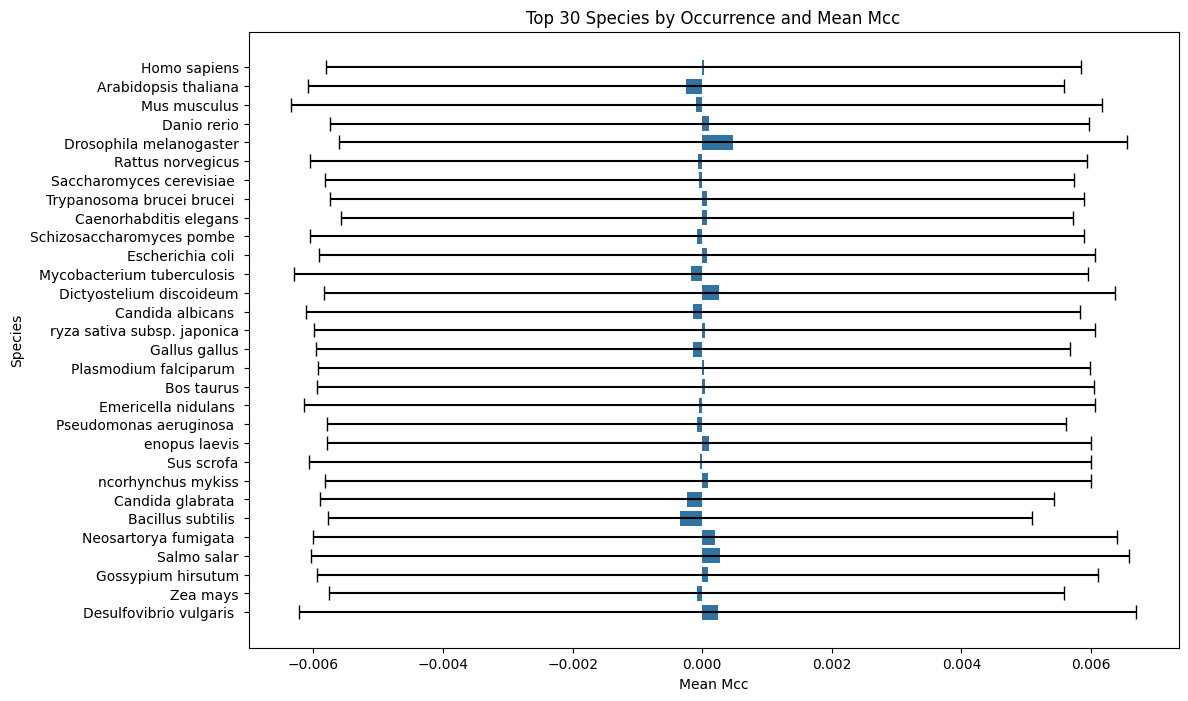

In [26]:
plot_top_species_metric(per_label_summary, dataset_test, metric="mcc", top_n=30)


C:\Users\49176\AppData\Local\Temp\ipykernel_4056\727873613.py:42: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


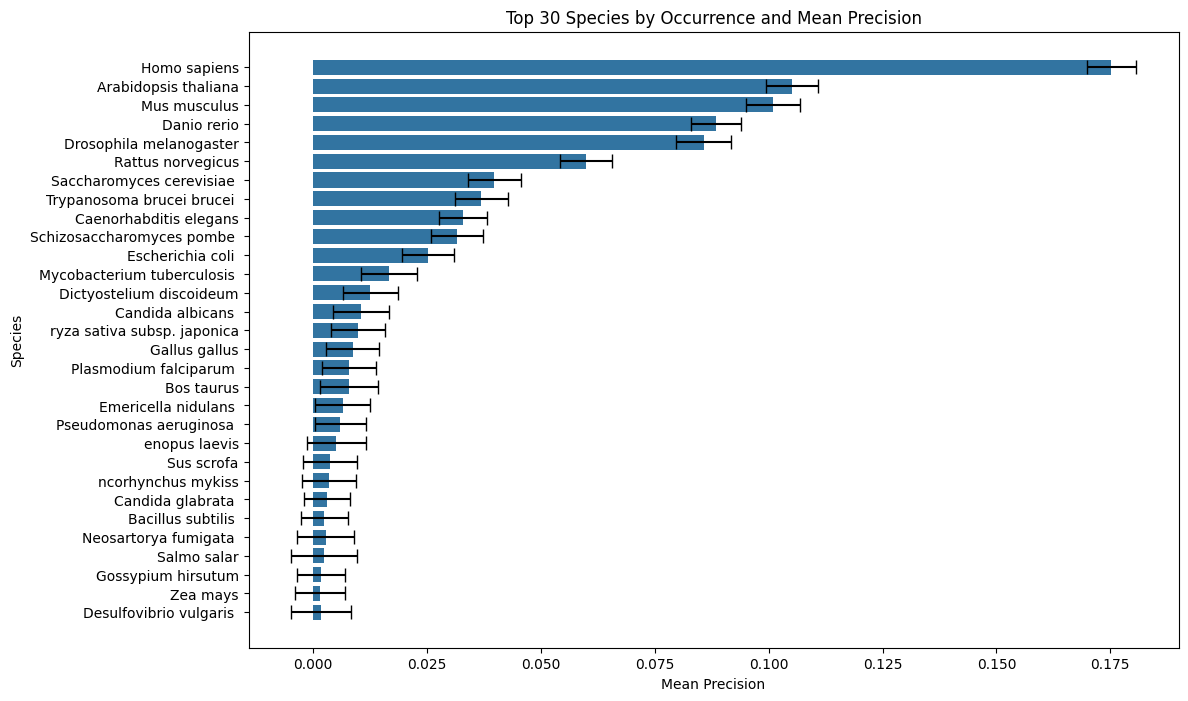

In [27]:
plot_top_species_metric(per_label_summary, dataset_test, metric="precision", top_n=30)

C:\Users\49176\AppData\Local\Temp\ipykernel_4056\727873613.py:42: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


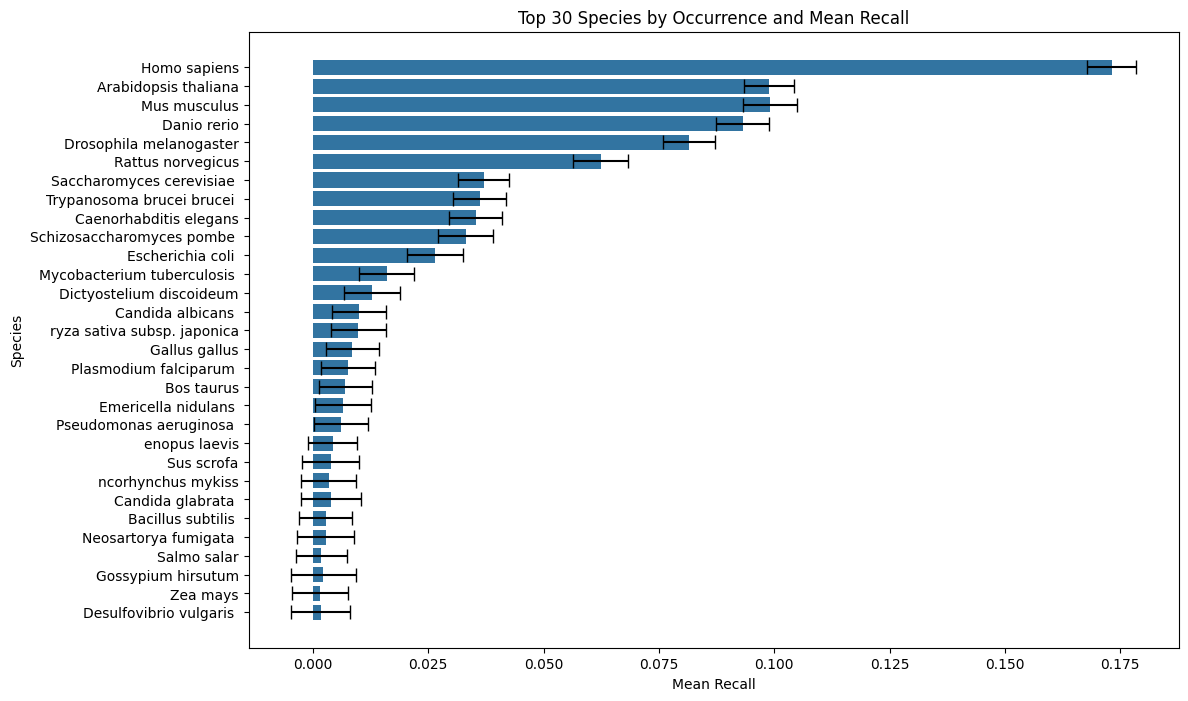

In [31]:
plot_top_species_metric(per_label_summary, dataset_test, metric="recall", top_n=30)

Precison 

## Confusion Matrix

In [33]:


def plot_confusion_matrix_heatmap_large(y_true, y_pred, label_range=None, figsize=(12, 10)):
    """
    Computes and plots a confusion matrix as a heatmap without annotations, 
    sorted by label prevalence, with the option to select a subset of labels.

    Parameters:
    - y_true: list or array, true labels.
    - y_pred: list or array, predicted labels.
    - label_range: tuple, optional, (start, end) indices for selecting a subset of labels by prevalence.
                   For example, (0, 10) will select the top 10 labels by prevalence.
    - figsize: tuple, optional, figure size for the plot.
    """
    
    # Calculate label prevalence and sort labels by frequency in y_true
    label_counts = Counter(y_true)
    sorted_labels = [label for label, _ in label_counts.most_common()]
    
    # Select a subset of labels if label_range is specified
    if label_range is not None:
        start, end = label_range
        selected_labels = sorted_labels[start:end]
    else:
        selected_labels = sorted_labels
    
    # Compute the confusion matrix with the selected labels
    cm = confusion_matrix(y_true, y_pred, labels=selected_labels)
    
    # Plot the heatmap without annotations for a cleaner view
    plt.figure(figsize=figsize)
    sns.heatmap(cm, cmap="Blues", xticklabels=selected_labels, yticklabels=selected_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix Heatmap (Sorted by Prevalence)")
    plt.show()


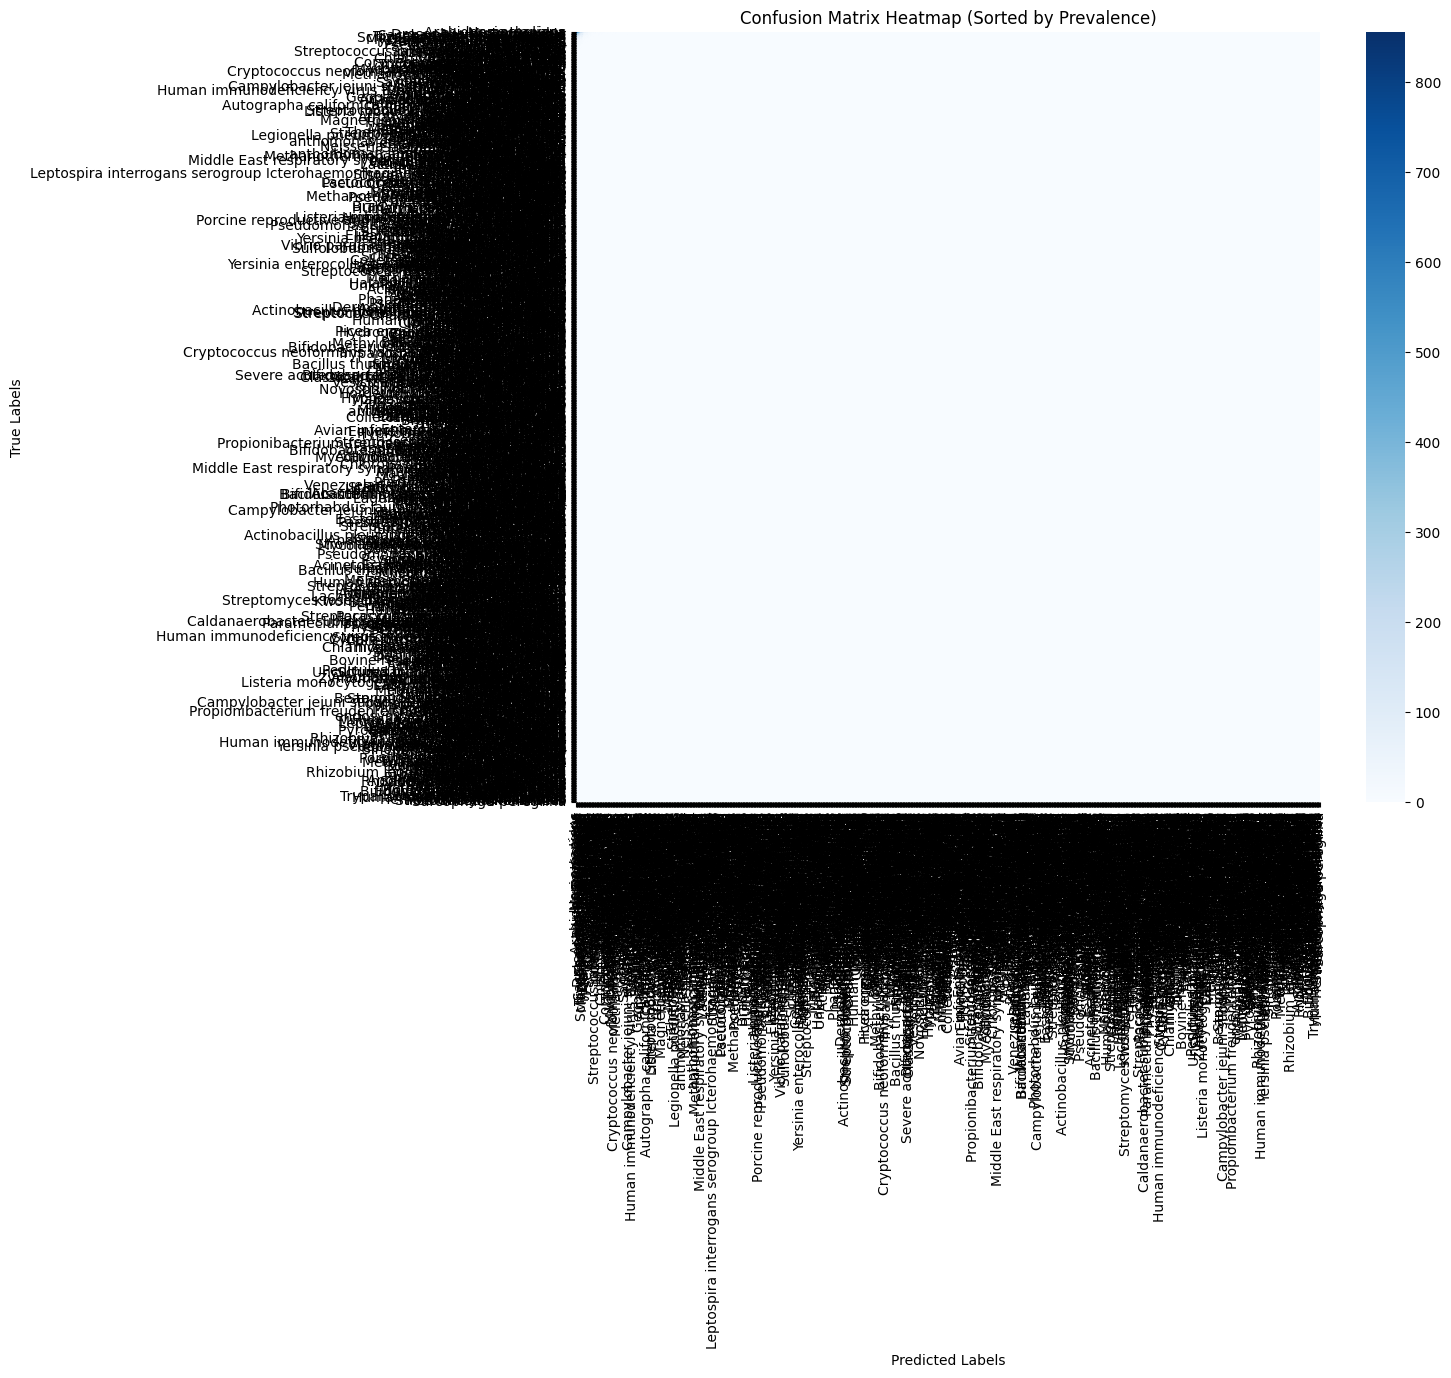

In [34]:
# Assuming y_true and y_pred contain your actual and predicted labels
plot_confusion_matrix_heatmap_large(dataset_test['species'], dataset_test["baseline"])
